# SQL-4. Сложные объединения

## 1. Знакомимся с данными

✍ Вы уже умеете присоединять строки друг к другу путём добавления столбцов «сбоку» — с помощью различных видов JOIN.

?
А что если нам необходимо присоединить несколько результатов «снизу», так, чтобы получить общий результат в выводе?

Ответу на этот вопрос и посвящён текущий модуль.

Но прежде, как всегда, разберёмся с датасетом ↓

В данном блоке мы будем работать с данными о компании, организующей перевозки грузов.

Есть данные о компании, организующей перевозки грузов. Интересующие нас данные хранятся в таблицах city, customer, driver, shipment, truck. 
Ниже представлена ER-диаграмма (от англ. entity-relation, дословно — «сущность-связь»), которая отображает существующие связи между отдельными таблицами.

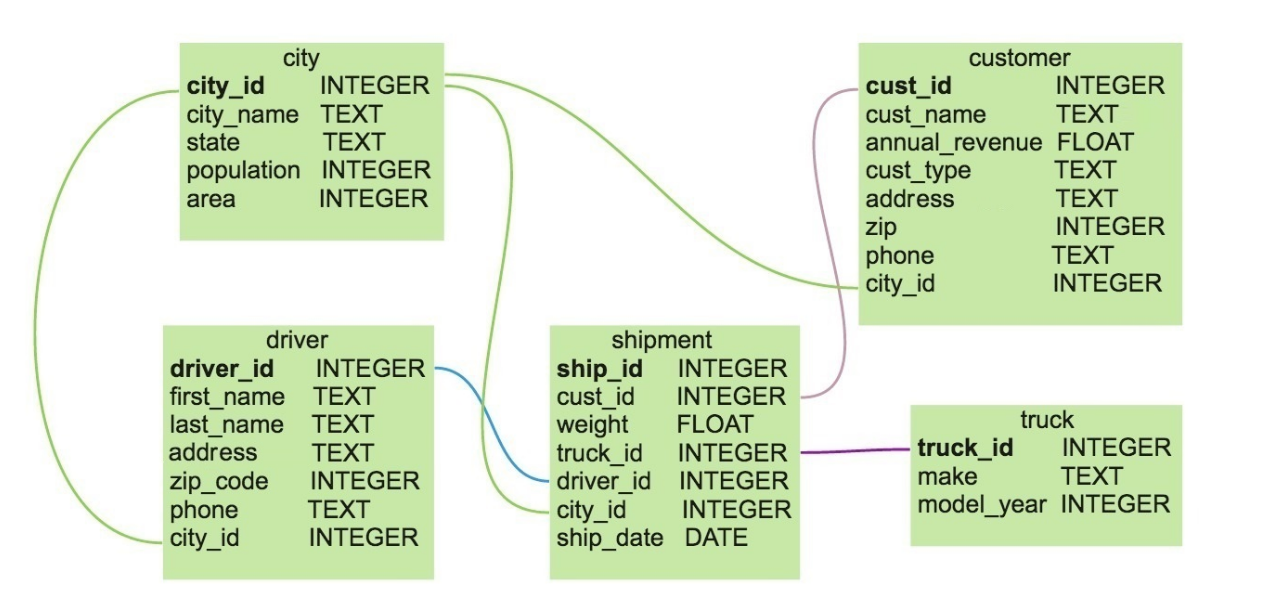

Таблица city — это справочник городов. Структура справочника представлена ниже.

Название поля	Тип данных	Описание
city_id	integer	уникальный идентификатор города, первичный ключ
city_name	text	название города
state	text	штат, к которому относится город
population	integer	население города
area	numeric	площадь города

Таблица customer — это справочник клиентов. У компании, с данными которой мы работаем, только корпоративные клиенты, поэтому в таблице нет привычных данных о возрасте и поле. Справочник содержит следующие поля:

Название поля	Тип данных	Описание
cust_id	integer	уникальный идентификатор клиента, первичный ключ
cust_name	text	название клиента
annual_revenue	numeric	ежегодная выручка
cust_type	text	тип пользователя
address	text	адрес
zip	integer	почтовый индекс
phone	text	телефон
city_id	integer	идентификатор города, внешний ключ к таблице city

Следующая таблица — driver — справочник водителей. Перечень сведений, содержащихся в таблице, представлен ниже.

Название поля	Тип данных	Описание
driver_id	integer	уникальный идентификатор водителя, первичный ключ
first_name	text	имя водителя
last_name	text	фамилия водителя
address	text	адрес водителя
zip_code	integer	почтовый индекс водителя
phone	text	телефон водителя
city_id	integer	идентификатор города водителя, внешний ключ к таблице city

В таблице truck хранится информация о грузовиках, на которых осуществляются перевозки. Данные о них представлены в следующем виде:

Название поля	Тип данных	Описание
truck_id	integer	Уникальный идентификатор грузовика, первичный ключ
make	text	Производитель грузовика
model_year	integer	Дата выпуска грузовика

Последняя таблица в датасете, shipment, — таблица с данными непосредственно о доставках. Она описывает взаимодействие всех перечисленных сущностей, а потому содержит наибольшее количество ссылок на другие таблицы.

Название поля	Тип данных	Описание
ship_id	integer	уникальный идентификатор доставки, первичный ключ
cust_id	integer	идентификатор клиента, которому отправлена доставка, внешний ключ к таблице customer
weight	numeric	вес посылки
truck_id	integer	идентификатор грузовика, на котором отправлена доставка, внешний ключ
к таблице truck
driver_id	integer	идентификатор водителя, который осуществлял доставку, внешний ключ к таблице driver
city_id	integer	идентификатор города в который совершена доставка, внешний ключ
к таблице city
ship_date	date	дата доставки

select *
FROM 
    sql.shipment s
    join sql.city c ON s.city_id = c.city_id
    join sql.driver d ON s.driver_id = d.driver_id
    join sql.customer cs ON s.cust_id = cs.cust_id
    join sql.truck t ON s.truck_id = t.truck_id
LIMIT 10

### Задание 1.1
6 points possible (graded)


→ Укажите название города с максимальным весом единичной доставки.

Green Bay

select 
    c.city_name,
    MAX(weight)
FROM 
    sql.shipment s
    join sql.city c ON s.city_id = c.city_id
    join sql.driver d ON s.driver_id = d.driver_id
    join sql.customer cs ON s.cust_id = cs.cust_id
    join sql.truck t ON s.truck_id = t.truck_id
GROUP BY c.city_name
ORDER BY MAX(weight) DESC
LIMIT 1

→ Сколько различных производителей грузовиков перечислено в таблице truck?

3

select 
    count(distinct t.make)
FROM 
     sql.truck t


→ Как зовут водителя (first_name), который совершил наибольшее количество доставок одному клиенту?

Holger

select 
    d.first_name
FROM 
    sql.shipment s
    join sql.city c ON s.city_id = c.city_id
    join sql.driver d ON s.driver_id = d.driver_id
    join sql.customer cs ON s.cust_id = cs.cust_id
    join sql.truck t ON s.truck_id = t.truck_id
GROUP BY s.cust_id, d.first_name, d.last_name
ORDER BY count(s.cust_id) DESC
LIMIT 1

→ Укажите даты первой и последней по времени доставок в таблице shipment.
Ответ введите в формате ДД.ММ.ГГГГ.

январь 8, 2016
декабрь 27, 2017

08.01.2016
27.12.2017

select 
    min(s.ship_date) min_ship_date,
    max(s.ship_date) max_ship_date
FROM 
    sql.shipment s


→ Укажите имя клиента, получившего наибольшее количество доставок за 2017 год.

Autoware Inc

select 
    cs.cust_name
FROM 
    sql.shipment s
    join sql.city c ON s.city_id = c.city_id
    join sql.driver d ON s.driver_id = d.driver_id
    join sql.customer cs ON s.cust_id = cs.cust_id
    join sql.truck t ON s.truck_id = t.truck_id
GROUP BY cs.cust_id, cs.cust_name
ORDER BY count(s.cust_id) DESC
LIMIT 1

## 2. UNION

### Принцип и условия работы Union

✍ Вернёмся к центральному вопросу модуля: как соединить несколько результатов, чтобы получить в выводе один общий?

Чтобы разобраться в этом вопросе, смоделируем ситуацию.

Допустим, мы хотим собрать из справочников по книгам и фильмам один, так чтобы в нём содержались названия произведений, а также их описание — книга или фильм.

Для этого напишем простой запрос:

ЗапросДетализация
SELECT          book_name object_name, 'книга' object_description 
FROM          public.books
UNION ALL
SELECT          movie_title, 'фильм' 
FROM          sql.kinopoisk
Визуально произведённое нами действие можно представить следующим образом:

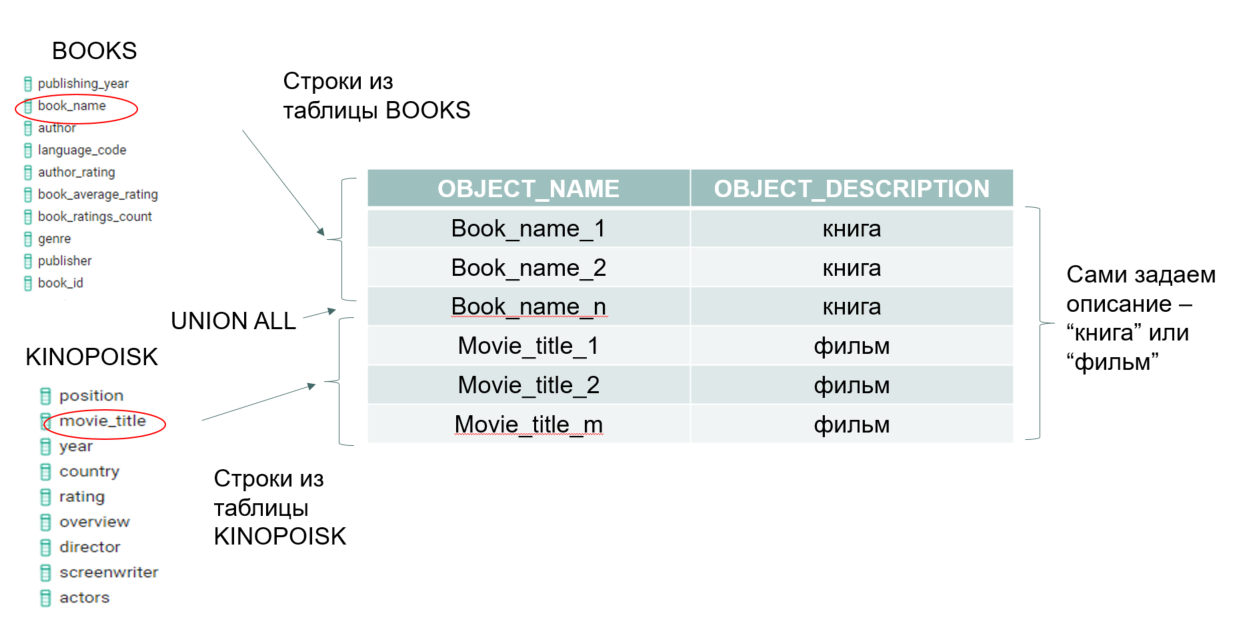

В запросе мы использовали оператор UNION ALL — он присоединяет любой результат запроса к другому «снизу» при условии, что у них одинаковая структура, а именно:

одинаковый тип данных;
одинаковое количество столбцов;
одинаковый порядок столбцов согласно типу данных.

### Виды UNION

Оператор присоединения существует в двух вариантах:

**UNION выводит только уникальные записи;**

UNION ALL присоединяет все строки последующих таблиц к предыдущим, без ограничений по уникальности.

*Важно! UNION оставляет только уникальные значения, а потому требует дополнительных вычислительных мощностей и памяти (в данном случае можно провести аналогию с DISTINCT).* 
Поэтому если вы уверены в отсутствии дубликатов в данных или они вам не важны, предпочтительнее использовать UNION ALL.
Проверить, как различаются операторы, вы сможете при выполнении заданий 2.1 и 3.1.

### Синтаксис

Запрос строится таким образом:

SELECT         n columns
FROM 
         table_1
UNION ALL
SELECT 
         n columns
FROM 
         table_2
...
UNION ALL
SELECT 
         n columns
FROM 
         table_n

Результатом выполнения такого запроса будут строки table_1, table_2, ..., table_n, соединённые одни под другими и выведенные в единой выдаче.

Важно! Названия итоговых колонок в выводе будут такие же, как в первом блоке SELECT, даже если они отличаются в других блоках подзапросов.

Пришла пора испытать функцию UNION(ALL) на практике.

Обратимся к нашему датасету о транспортной компании и посмотрим, как сформировать справочник с ID всех таблиц и указанием объекта, к которому он относится.

SELECT
         c.city_id object_name,  'id города' object_type /*выбираем колонку city_id и задаём ей алиас object_name, сами задаём объект 'id города' и название столбца object_type*/
FROM 
         sql.city c /*из схемы sql и таблицы city, задаём алиас таблице — с*/
UNION ALL /*оператор присоединения*/
SELECT
         d.driver_id other_name,  'id водителя' other_type /*выбираем колонку driver_id и задаём ей алиас other_name, сами задаём объект 'id водителя' и название столбца other_type*/
FROM 
         sql.driver d  /*из схемы sql и таблицы driver, задаём алиас таблице — d*/
UNION ALL /*оператор присоединения*/
SELECT
         s.ship_id,  'id доставки' /*выбираем колонку ship_id, сами задаём объект 'id доставки'*/
FROM 
         sql.shipment s /*из схемы sql и таблицы shipment, задаём алиас таблице — s*/
UNION ALL /*оператор присоединения*/
SELECT
         c.cust_id,  'id клиента' /*выбираем колонку cust_id, сами задаём объект 'id клиента'*/
FROM 
         sql.customer c /*из схемы sql и таблицы customer, задаём алиас таблице — c*/
UNION ALL /*оператор присоединения*/
SELECT
         t.truck_id,  'id грузовика' /*выбираем колонку truck_id, сами задаём объект 'id грузовика'*/
FROM 
         sql.truck t /*из схемы sql и таблицы truck, задаём алиас таблице — t*/
ORDER BY 1 /*сортировка по первому столбцу*/

Обратите внимание! Несмотря на исходные названия колонок other_name и other_type во втором подзапросе, в выводе мы получим названия, которые дали в первом блоке: object_name и object_type.

Другая особенность — в применении сортировки ORDER BY: она всегда будет относиться к итоговому результату всего запроса с UNION ALL.

В случаях, когда необходимо применить команду ORDER BY или LIMIT не к итоговому результату, а к каждой части запроса, можно обернуть подзапросы в скобки.

Чтобы посмотреть, как это работает, вернёмся к нашему примеру с общим справочником по фильмам и книгам.

Мы уже знаем, что можно легко и непринуждённо применить операторы ORDER BY и LIMIT ко всему результату запроса.

SELECT book_name object_name, 'книга' object_descritption 
FROM public.books
UNION ALL
SELECT movie_title, 'фильм' 
FROM sql.kinopoisk
ORDER BY 1
LIMIT 1

Всё бы хорошо, только в таком случае отсортирован будет весь общий справочник, а в выводе останется одна строка с названием объекта, идущим первым по алфавиту.

А если мы не хотим общую сортировку? Может, нам нужны строки с названием как фильма, так и книги, идущих первыми по алфавиту.

Нет ничего проще — отсортируем каждую часть запроса по отдельности и объединим результаты!

Просто добавим ORDER BY и LIMIT ещё и в первую часть запроса:

In [ ]:
SELECT book_name object_name, 'книга' object_descritption 
FROM public.books
ORDER BY 1
LIMIT 1
UNION ALL
SELECT movie_title, 'фильм' 
FROM sql.kinopoisk
ORDER BY 1
LIMIT 1

Вместо результата получим сообщение о синтаксической ошибке: "...syntax error at or near "UNION"..." Очевидно, этот фокус не удался.

Не стоит огорчаться, ведь проблему можно решить одним (ну, почти) движением руки — просто добавив скобки вокруг каждой из частей запроса.

(SELECT book_name object_name, 'книга' object_descritption 
FROM public.books
ORDER BY 1
LIMIT 1)
UNION ALL
(SELECT movie_title, 'фильм' 
FROM sql.kinopoisk
ORDER BY 1
LIMIT 1)

Отлично! Мы получили именно то, что хотели.

### Задание 2.1 (External resource)

Напишите запрос, который создает уникальный алфавитный справочник всех городов, штатов, имён водителей и производителей грузовиков. Результатом запроса должны быть два столбца: название и тип объекта (city, state, driver, truck). Отсортируйте список по названию объекта, а затем — по типу.

SELECT city_name AS name, 'city' object_descritption
FROM sql.city
UNION
SELECT state AS name, 'state' object_descritption
FROM sql.city
UNION
SELECT first_name || ' ' || last_name AS name, 'driver' object_descritption
FROM sql.driver
UNION
SELECT make AS name, 'truck' object_descritption
FROM sql.truck
ORDER BY name, object_descritption;

SELECT city_name AS name, 'city' object_descritption
FROM sql.city
UNION
SELECT state AS name, 'state' object_descritption
FROM sql.city
UNION
SELECT first_name AS name, 'driver' object_descritption
FROM sql.driver
UNION
SELECT make AS name, 'truck' object_descritption
FROM sql.truck
ORDER BY name, object_descritption;

### Задание 2.2 (External resource)

Напишите запрос, который соберёт имена всех упомянутых городов и штатов из таблицы city. Результатом запроса должен быть один столбец object_name, отсортированный в алфавитном порядке.

SELECT city_name AS name
FROM sql.city
UNION ALL
SELECT state AS name
FROM sql.city
ORDER BY name;

### Задание 2.3 (External resource)

Выполнив предыдущий запрос, мы получили города с одинаковыми названиями, но находящиеся в разных штатах, а также большое количество дублирующихся названий штатов. Перепишите предыдущий запрос так, чтобы остались только уникальные названия городов и штатов. Результатом запроса должен быть один столбец object_name, отсортированный в алфавитном порядке.

SELECT city_name AS name
FROM sql.city
UNION
SELECT state AS name
FROM sql.city
ORDER BY name;

## 3. UNION и ограничение типов данных

### Почему так важен тип данных?

Как мы уже знаем, UNION может быть использован только в случае полного соответствия столбцов и их типов в объединяемых запросах.

Допустим, мы хотим вывести список всех id городов и их названий в одном столбце.

Давайте напишем запрос, который позволит получить нужный нам результат.

SELECT 
         c.city_id /*выбираем столбец city_id*/
FROM
         sql.city c /*из схемы sql  и таблицы city, задаём таблице алиас с*/ 

UNION ALL /*оператор присоединения*/

SELECT 
         cc.city_name /*выбираем столбец city_name*/
FROM
         sql.city cc /*из схемы sql и таблицы city, задаём таблице алиас сс*/

         
Вместо результата вы получите сообщение об ошибке: "ERROR: UNION types integer and text cannot be matched". Дело в том, что мы попытались объединить числовой и строковый типы в одной колонке, а это невозможно.

Если мы всё же хотим выполнить поставленную задачу, придётся привести оба столбца к одному типу данных. Не каждый текст может быть приведён к числу, зато каждое число может быть представлено в текстовом формате.

Забегая вперёд, скажем пару слов о типизации столбцов. Для типизации в Postgres составляется запрос по модели **column_name::column_type**.

Таким образом, чтобы перевести city_id в текст, нам потребуется написать **city_id::text**.

Важно! Любой тип данных может быть приведён к текстовому формату — эту возможность целесообразно использовать для соединения разнородных сущностей. Главное — помнить, что сортировка текста отличается от сортировки чисел и дат.

Немного подправим запрос, чтобы получить желаемый результат.

SELECT 
         c.city_id::text
FROM
         sql.city c
UNION ALL
SELECT 
         cc.city_name
FROM
         sql.city cc

### Задание 3.1 (External resource)

Напишите запрос, который объединит в себе все почтовые индексы водителей и их телефоны в единый столбец-справочник contact. Также добавьте столбец с именем водителя first_name и столбец contact_type с типом контакта (phone или zip в зависимости от типа). Отсортируйте список по столбцу с контактными данными в порядке возрастания, а затем — по имени водителя.

SELECT 
         d.zip_code::text as contact,
         d.first_name as first_name,
         'zip' as contact_type
FROM
         sql.driver d
UNION ALL
SELECT
         d.phone as contact,
         d.first_name as first_name,
         'phone' as contact_type
FROM
         sql.driver d
ORDER BY contact_type, first_name;

## 4. UNION ALL и промежуточные итоги

## Возможности UNION

✍ Помимо соединения разнородных сущностей в единый справочник, UNION ALL часто используется для подведения промежуточных итогов и выведения результатов агрегатных функций.

Кроме агрегатных функций, в запросах с UNION могут использоваться функции группировки и выборки.

Попробуем вывести обобщённые данные о населении по всем городам, с детализацией до конкретного города.



SELECT
         c.city_name,
         c.population /*выбираем столбцы city_name, population*/
FROM
         sql.city c /*из схемы sql и таблицы city, задаём таблице алиас с*/

UNION ALL /*оператор присоединения*/

SELECT
         'total',
         SUM(c.population) /*сами задаём объект ‘total’, суммируем все значения столбца population*/
FROM
         sql.city c /*из схемы sql и таблицы city, задаём таблице алиас с*/
ORDER BY 2 DESC /*сортируем по второму столбцу в убывающем порядке (чтобы итоговая сумма была в начале)*/

Визуально это действие можно представить так:

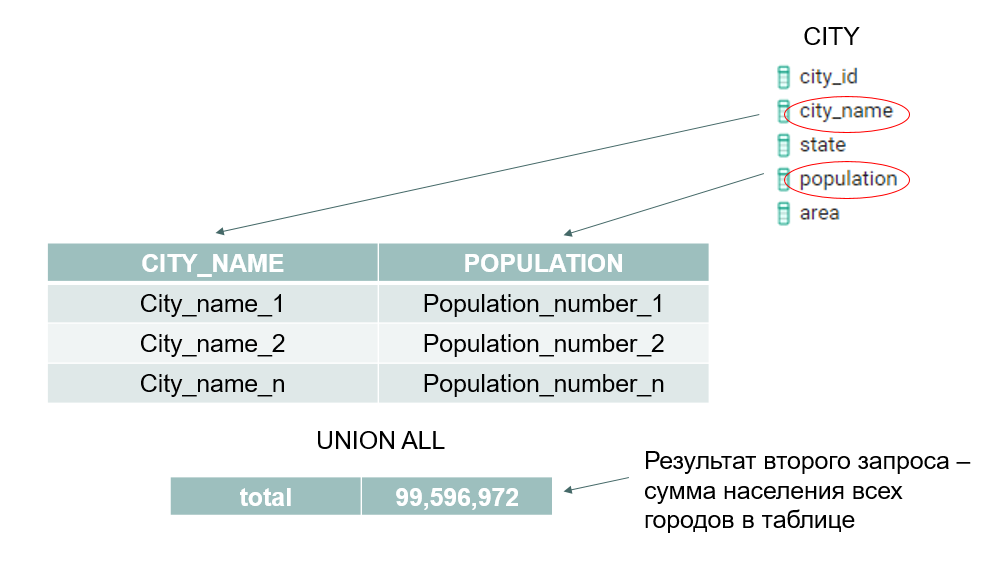

Выполнив запрос в Metabase, вы заметите, что сначала выведен итоговый результат с суммой населения всех городов в таблице, а затем по каждому городу в отдельности.



### Задание 4.1 (External resource)

Напишите запрос, который выводит общее число доставок total_shipments, а также количество доставок в каждый день. Необходимые столбцы: date_period, cnt_shipment. Не забывайте о единой типизации. Упорядочите по убыванию столбца date_period.

SELECT
        s.ship_date::text as date_period,
        count(s.ship_id) as cnt_shipment
FROM
        sql.shipment s
GROUP BY s.ship_date
UNION ALL
SELECT
        'total_shipments',
        count(s.ship_id)
FROM
        sql.shipment s
ORDER BY 2 DESC

## 5. UNION и дополнительные условия

✍ UNION также может быть использован для разделения существующей выборки по критерию «выполнение определённого условия».

Например, с помощью UNION можно отобразить, у кого из водителей заполнен столбец с номером телефона.



SELECT
         d.first_name,
         d.last_name,
         'телефон заполнен' phone_info /*выбираем столбцы first_name, last_name, сами выводим объект ‘телефон заполнен’*/
FROM
         sql.driver d /*из схемы sql и таблицы driver, задаём алиас d*/
WHERE d.phone IS NOT NULL /*условие, что телефон заполнен*/

UNION /*оператор присоединения (уникальные значения)*/

SELECT
         d.first_name,
         d.last_name,
         'телефон не заполнен' phone_info /*выбираем столбцы first_name, last_name, сами выводим объект ‘телефон не заполнен’*/
FROM
         sql.driver d /*из схемы sql и таблицы driver, задаём алиас d*/
WHERE d.phone IS NULL /*условие, что телефон не заполнен*/

### Задание 5.1 (External resource)

Напишите запрос, который выведет все города и штаты, в которых они расположены, а также информацию о том, была ли осуществлена доставка в этот город:

если в город была осуществлена доставка, то выводим 'доставка осуществлялась';
если нет — выводим 'доставка не осуществлялась'.
Столбцы к выводу: city_name, state, shipping_status. Отсортируйте в алфавитном порядке по городу, а затем — по штату.

SELECT 
    c.city_name,
    c.state,
    'доставка осуществлялась' shipping_status
FROM 
    sql.city c
    LEFT JOIN sql.shipment s ON s.city_id = c.city_id
WHERE s.ship_id IS NOT NULL

UNION

SELECT 
    c.city_name,
    c.state,
    'доставка не осуществлялась' shipping_status
FROM 
    sql.city c
    LEFT JOIN sql.shipment s ON s.city_id = c.city_id
WHERE s.ship_id IS  NULL

ORDER BY city_name, state ASC




### Задание 5.2 (External resource)

Напишите запрос, который выводит два столбца: city_name и shippings_fake. Выведите города, куда совершались доставки. Пусть первый столбец содержит название города, а второй формируется так:

если в городе было более десяти доставок, вывести количество доставок в этот город как есть;
иначе — вывести количество доставок, увеличенное на пять.
Отсортируйте по убыванию получившегося «нечестного» количества доставок, а затем — по имени в алфавитном порядке.

SELECT 
    c.city_name,
    count(s.ship_id) shippings_fake
FROM 
    sql.shipment s
    JOIN sql.city c ON s.city_id = c.city_id
GROUP BY c.city_name
HAVING count(s.ship_id) > 10

UNION

SELECT 
    c.city_name,
    count(s.ship_id)+5 shippings_fake
FROM 
    sql.shipment s
    JOIN sql.city c ON s.city_id = c.city_id
GROUP BY c.city_name
HAVING count(s.ship_id) <= 10

ORDER BY shippings_fake DESC, city_name ASC

В данном случае лучше использовать JOIN (или INNER JOIN), а не LEFT JOIN. Вот почему:

JOIN (или INNER JOIN): Этот тип соединения возвращает только те строки, которые имеют соответствующие записи в обеих таблицах. В нашем случае это означает, что будут выбраны только те доставки, для которых существует соответствующий город в таблице city. Это логично, так как каждая доставка должна быть связана с каким-то городом.

LEFT JOIN: Этот тип соединения возвращает все строки из левой таблицы (в данном случае shipment), даже если нет соответствующих записей в правой таблице (city). Если бы мы использовали LEFT JOIN, то в результатах могли бы появиться доставки, для которых нет соответствующего города, что не имеет смысла в контексте данной задачи.

Таким образом, использование JOIN (или INNER JOIN) гарантирует, что мы получаем только те доставки, которые связаны с существующими городами, что соответствует логике задачи.

SELECT 
    c.city_name,
    CASE 
        WHEN COUNT(s.ship_id) > 10 THEN COUNT(s.ship_id)
        ELSE COUNT(s.ship_id) + 5
    END AS shippings_fake
FROM 
    sql.shipment s
JOIN 
    sql.city c ON s.city_id = c.city_id
GROUP BY 
    c.city_name
ORDER BY 
    shippings_fake DESC, 
    c.city_name ASC;

Это решение от Copilot

## 6. UNION и ручная генерация

✍ UNION можно использовать для создания справочников прямо в коде запроса. К примеру, если мы хотим вручную ввести какие-то значения и произвести с ними некоторые манипуляции или дополнить существующую выдачу своими значениями.


Составим запрос, который позволит вывести первые три буквы алфавита и их порядковые номера.

SELECT 
         'a' letter,'1' ordinal_position
UNION 
SELECT 
         'b','2'
UNION 
SELECT
         'c','3'

Существуют сложные алгоритмы сравнения текстовых значений, но главный смысл сводится к одному: сравнение производится на основе таблицы unicode и позиции элемента в ней с учётом определённых условий.

### Задание 6.1 (External resource)

Напишите запрос, который выберет наибольшее из числовых значений:

1000000;
541;
-500;
100.
Столбец с результатом назовите result.

SELECT 1000000 AS result
UNION
SELECT 541 AS result
UNION
SELECT -500 AS result
UNION
SELECT 100 AS result
ORDER BY result DESC
LIMIT 1;

### Задание 6.2 (External resource)

Помним, что сортировка для числовых и строковых типов данных отличается. Построив запрос по аналогии с примером, приведите значения к текстовому типу данных, сравните и выберите наибольшее из них:

1000000;
541;
-500;
100.
Столбец с ответом назовите mycol

SELECT 1000000::text AS mycol
UNION
SELECT 541::text
UNION
SELECT (-500)::text
UNION
SELECT 100::text
ORDER BY mycol DESC
LIMIT 1;

### Задание 6.3 (External resource)

Построив запрос по аналогии с примером, найдите самое большое значение из перечисленных операторов:

+ ;
- ;
= ;
/ .
Столбец с ответом назовите result.

Ответ:
+

SELECT '+'::text AS result
UNION
SELECT '-'::text
UNION
SELECT '='::text
UNION
SELECT '/'::text
ORDER BY result DESC
LIMIT 1;

## 7. EXCEPT

### Исключаем повторяющиеся данные

Предположим, нам нужно узнать, в какие города осуществлялась доставка, за исключением тех, в которых проживают водители.

SELECT
         c.city_name
FROM
         sql.shipment s
JOIN sql.city c ON s.city_id = c.city_id
EXCEPT
SELECT
         cc.city_name
FROM
         sql.driver d 
JOIN sql.city cc ON d.city_id=cc.city_id
ORDER BY 1

Все водители проживают в городе Memphis, и мы видим, что он не выводится в результате запроса.

Как вы, должно быть, заметили, для решения этой задачи мы использовали оператор EXCEPT. Принципы его работы мы сейчас разберём ↓

Чтобы лучше понять данный тип присоединения, предлагаем ознакомиться с **диаграммой Венна** — математическим инструментом, представляющим возможные логические связи между соединёнными наборами данных.



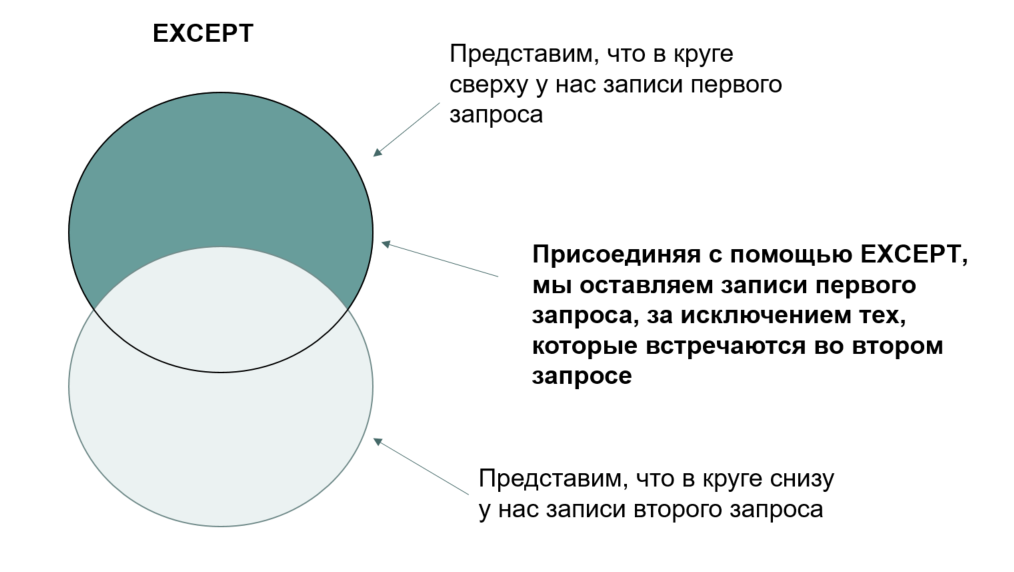

Синтаксические правила для оператора EXCEPT такие же, как и для UNION:

одинаковый тип данных;

одинаковое количество столбцов;

одинаковый порядок столбцов согласно типу данных.

Синтаксис выглядит следующим образом:

SELECT 
         n columns
FROM 
         table_1
EXCEPT
SELECT 
         n columns
FROM 
         table_2

Мы уже знаем, как решить такую задачу с использованием LEFT JOIN. Вариант с EXCEPT будет полезен в тех случаях, когда у вас много столбцов и вам не хочется прописывать их равенство в условии для JOIN.

Предположим, у нас есть информация о продажах канцелярского магазина за май и июнь.

Какие-то позиции продавались и в том, и в другом месяце, а какие-то — только в одном. Использовав EXCEPT, мы можем оставить только те товары, которые есть в первом запросе (например, за май), но отсутствуют во втором запросе (например, за июнь).

Графически действие оператора можно представить следующим образом:

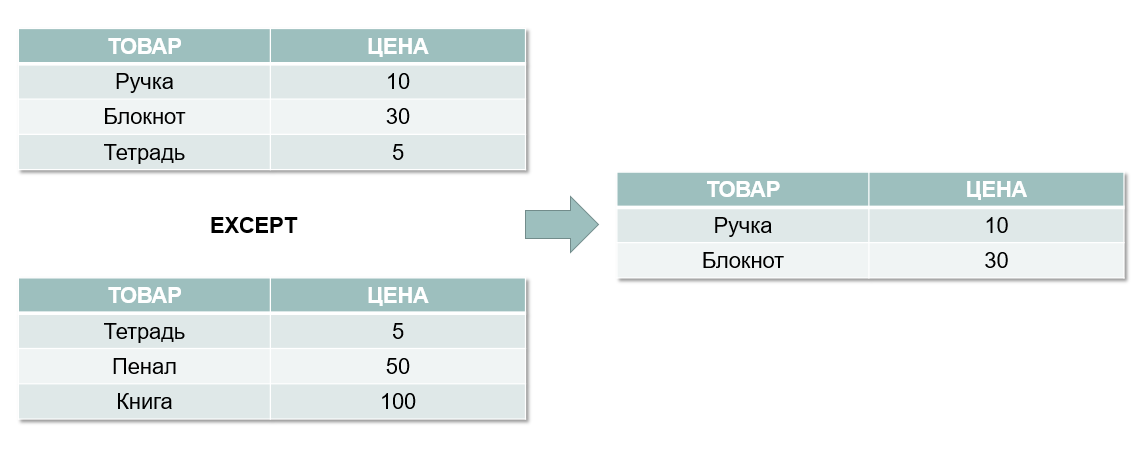

Таким образом, при присоединении с помощью EXCEPT мы вывели только те товары, которые были проданы в мае, но не в июне. Чтобы найти продажи по тем позициям, что были реализованы в июне, а в мае — нет, необходимо поменять запросы местами.


### Задание 7.1 (External resource)

Выведите список zip-кодов, которые есть в таблице sql.driver, но отсутствуют в таблице sql.customer. Отсортируйте по возрастанию, столбец к выводу — zip. В поле ниже введите запрос, с помощью которого вы решили эту задачу.

SELECT
         d.zip_code as zip
FROM
         sql.driver d

EXCEPT
SELECT
         cs.zip
FROM
         sql.customer cs
ORDER BY 1

## 8. INTERSECT

Выбираем общие данные

А что если нам надо вывести общие записи — те, что существуют в нескольких таблицах?

Предположим, нам надо вывести совпадающие по названию города и штаты.



SELECT          c.city_name object_name
FROM          sql.city c
INTERSECT
SELECT 
         cc.state
FROM          sql.city cc
ORDER BY 1

Как видим, с помощью оператора INTERSECT мы вывели названия городов и штатов, которые совпадают: New York, Washington и Wyoming. Присмотримся к нему внимательнее.

Чтобы лучше понять, как работает этот оператор, вновь обратимся к диаграмме Венна: INTERSECT оставляет из результатов первого запроса все строки, которые совпали с результатом выполнения второго запроса.

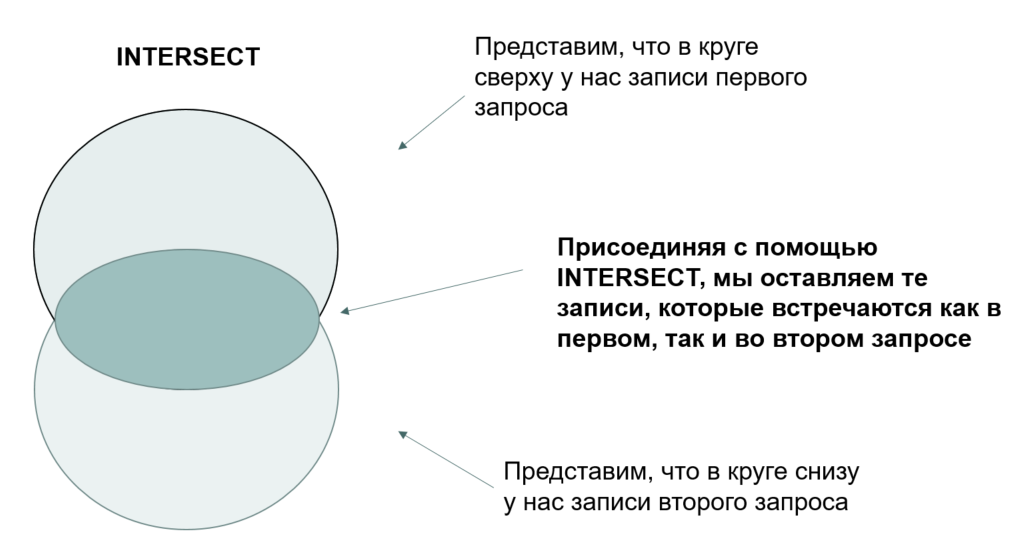

Синтаксис запроса с оператором INTERSECT выглядит следующим образом:

SELECT 
         n columns
FROM 
         table_1
INTERSECT
SELECT 
         n columns
FROM 
         table_2

Вернёмся к нашему примеру с продажами канцтоваров.

С помощью оператора INTERSECT мы можем вывести те позиции, которые продавались и в мае, и в июне. Визуализировать это действие можно примерно так:

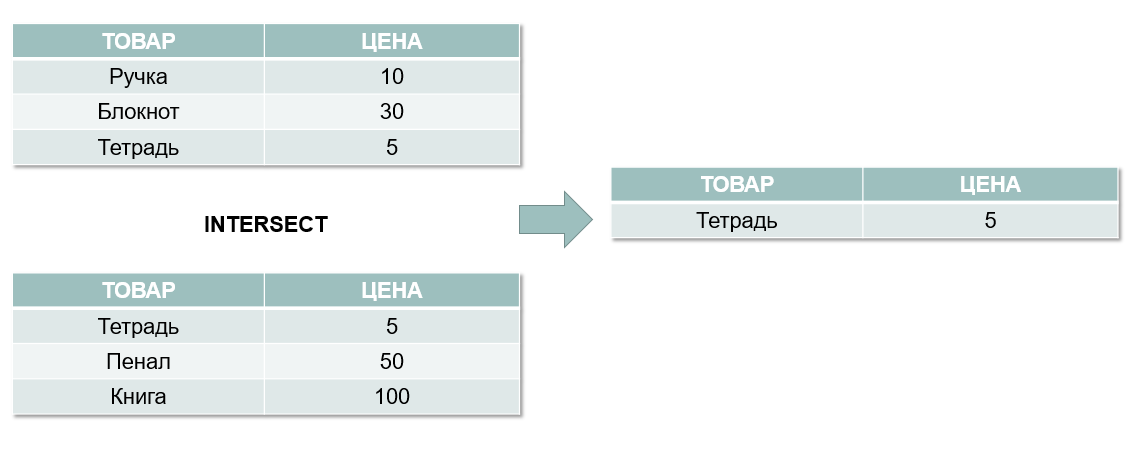

Оператор INTERSECT оставляет только те строки, которые являются общими для двух запросов (в нашем примере это Тетрадь).

Как EXCEPT, так и INTERSECT убирают дубликаты, если они имеются.

### Задание 8.1 (External resource)

Напишите запрос, который выведет список id городов, в которых есть и клиенты, и доставки, и водители.

Ответ:
682

Memphis

SELECT 
    cs.city_id object_name
FROM    
    sql.customer cs
INTERSECT
SELECT
        s.city_id
FROM
         sql.shipment s
INTERSECT
SELECT
        d.city_id
FROM
         sql.driver d

А это решение с названиями городов

SELECT 
    c.city_name object_name
FROM    
    sql.customer cs
JOIN sql.city c ON cs.city_id = c.city_id
INTERSECT
SELECT
         c.city_name
FROM
         sql.shipment s
JOIN sql.city c ON s.city_id = c.city_id
INTERSECT
SELECT
         c.city_name
FROM
         sql.driver d
JOIN sql.city c ON d.city_id = c.city_id

### Задание 8.2 (External resource)

Выведите zip-код, который есть как в таблице с клиентами, так и в таблице с водителями.

Ответ: 
38109

SELECT 
    cs.zip zip_code
FROM    
    sql.customer cs

INTERSECT

SELECT
        d.zip_code
FROM
         sql.driver d

### 9. Итоги. Закрепление знаний

✍ В этом модуле вы освоили ещё несколько возможностей из функционала SQL.

Теперь вы умеете:

присоединять таблицы «снизу», одну под другой;

исключать или, наоборот, выбирать повторяющиеся записи из двух таблиц;

вручную добавлять записи в таблицу.

Запишем структуру запроса с учётом полученных знаний.

SELECT          N columns
FROM          table_1
UNION / UNION ALL / EXCEPT / INTERSECT 
SELECT          N columns
FROM          table_2

Дополнительные сведения

Напоследок разберём несколько вопросов, которые часто задают на собеседованиях ↓

✍ Теперь осталось только проверить, насколько хорошо вы усвоили материал ↓



### Задание 9.1 (External resource)

Выведите города с максимальным и минимальным весом единичной доставки. Столбцы к выводу — city_name, weight.

(SELECT
         c.city_name,
         MAX(s.weight) weight
FROM
         sql.shipment s
JOIN sql.city c ON s.city_id = c.city_id
GROUP BY c.city_name
ORDER BY weight DESC
LIMIT 1)

UNION ALL
(SELECT
         c.city_name,
         MIN(s.weight) weight
FROM
         sql.shipment s
JOIN sql.city c ON s.city_id = c.city_id
GROUP BY c.city_name
ORDER BY weight ASC
LIMIT 1)


Отличное решение! Обернув оба запроса в скобки, вы смогли обойти ограничение на использование ORDER BY и LIMIT внутри UNION. Это действительно элегантный способ решения задачи.

### Задание 9.2 (External resource)

Выведите идентификационные номера клиентов (cust_id), которые совпадают с идентификационными номерами доставок (ship_id). Столбец к выводу — mutual_id. Отсортируйте по возрастанию.

SELECT 
    cs.cust_id mutual_id
FROM    
    sql.customer cs

INTERSECT

SELECT
        s.ship_id
FROM
         sql.shipment s
ORDER BY mutual_id ASC

### Задание 9.3 (External resource)

Создайте справочник, содержащий уникальные имена клиентов, которые являются производителями (cust_type='manufacturer'), и производителей грузовиков, а также описание объекта — 'КЛИЕНТ' или 'ГРУЗОВИК'. Столбцы к выводу — object_name, object_description. Отсортируйте по названию в алфавитном порядке.

(
SELECT 
    cs.cust_name object_name,
    'КЛИЕНТ' object_description
FROM 
    sql.customer cs
WHERE cs.cust_type='manufacturer'
)
UNION

(
SELECT 
    t.make object_name,
    'ГРУЗОВИК' object_description
FROM 
    sql.truck t
)

ORDER BY object_name ASC

И это ещё не всё!

Знания по темам этого модуля зачастую проверяют работодатели на собеседованиях. Предлагаем вам ознакомиться с вопросами, с которыми вы можете столкнуться при поиске работы. 

Важно! Это задания на самопроверку, они необязательные и мы не будем оценивать качество их решения. На некоторые вопросы будет предоставляться ответ, а на некоторые — нет. Настоятельно рекомендуем вам попробовать найти ответ самостоятельно, прежде чем открывать его.

⚡ Мы не добавляем скрипты для таблиц, которые нужны для заданий, так как именно в таком виде их получают кандидаты на собеседованиях.

Вопрос 1 Скачайте [файл](https://lms-cdn.skillfactory.ru/assets/courseware/v1/fb9124cd203bfaf5573ecf478899c6fc/asset-v1:SkillFactory+DSPRMGU+2023_FEB+type@asset+block/SQL_test1.xlsx) и выполните задания в нём.

Я ознакомился с содержимым файла SQL_test1.xlsx. В нем представлены четыре таблицы: clients, sales, sales_details и goods, а также несколько задач, связанных с данными в этих таблицах. Вот краткое описание таблиц и полей:

Таблицы и поля
clients

client_id: Уникальный ID записи
client_name: ФИО клиента
date_of_birth: Дата рождения клиента
client_type: Тип клиента
sales

sale_id: Уникальный ID записи
client_id: Идентификатор клиента
revenue: Выручка
date_sale: Дата продажи
manager_id: ФИО менеджера
sales_details

sales_details_id: Уникальный ID записи
sale_id: ID продажи (не уникальный)
date_sale: Дата продажи
goods_id: Идентификатор продукта
goods_count: Количество продукта
price: Цена реализации
goods

goods_id: Идентификатор продукта
goods_name: Название продукта
type_of_goods: Тип продукта
category: Категория продукта


Задачи и решения

Вывести список ФИО клиентов, которые покупали продукты компании в этом году:

SELECT DISTINCT c.client_name
FROM clients c
JOIN sales s ON c.client_id = s.client_id
WHERE EXTRACT(YEAR FROM s.date_sale) = EXTRACT(YEAR FROM CURRENT_DATE);



Вывести список клиентов, у которых день рождения сегодня:

SELECT client_name
FROM clients
WHERE TO_CHAR(date_of_birth, 'MM-DD') = TO_CHAR(CURRENT_DATE, 'MM-DD');



Вывести объём выручки продаж этого года по менеджерам:

SELECT manager_id, SUM(revenue) AS total_revenue
FROM sales
WHERE EXTRACT(YEAR FROM date_sale) = EXTRACT(YEAR FROM CURRENT_DATE)
GROUP BY manager_id;


Вывести все уникальные сочетания двух категорий продуктов (в рамках одной продажи), которые были куплены сегодня:

SELECT DISTINCT g1.category || '-' || g2.category AS category_combination
FROM sales_details sd1
JOIN goods g1 ON sd1.goods_id = g1.goods_id
JOIN sales_details sd2 ON sd1.sale_id = sd2.sale_id
JOIN goods g2 ON sd2.goods_id = g2.goods_id
JOIN sales s ON sd1.sale_id = s.sale_id
WHERE s.date_sale = CURRENT_DATE
  AND sd1.goods_id <> sd2.goods_id
  AND sd1.sale_id = sd2.sale_id;




Вывести среднемесячную выручку продаж этого года на каждого менеджера по продажам, в которых была реализация продукта из категории "Колбаса":

SELECT s.manager_id, AVG(monthly_revenue) AS avg_monthly_revenue
FROM (
    SELECT manager_id, EXTRACT(MONTH FROM date_sale) AS sale_month, SUM(revenue) AS monthly_revenue
    FROM sales s
    JOIN sales_details sd ON s.sale_id = sd.sale_id
    JOIN goods g ON sd.goods_id = g.goods_id
    WHERE EXTRACT(YEAR FROM s.date_sale) = EXTRACT(YEAR FROM CURRENT_DATE)
      AND g.category = 'Колбаса'
    GROUP BY manager_id, EXTRACT(MONTH FROM date_sale)
) AS monthly_sales
GROUP BY manager_id;

Я ознакомился с содержимым файла SQL_test1.xlsx. В нем представлены четыре таблицы: clients, sales, sales_details и goods, а также несколько задач, связанных с данными в этих таблицах. Вот краткое описание таблиц и полей:

Таблицы и поля
clients

client_id: Уникальный ID записи
client_name: ФИО клиента
date_of_birth: Дата рождения клиента
client_type: Тип клиента
sales

sale_id: Уникальный ID записи
client_id: Идентификатор клиента
revenue: Выручка
date_sale: Дата продажи
manager_id: ФИО менеджера
sales_details

sales_details_id: Уникальный ID записи
sale_id: ID продажи (не уникальный)
date_sale: Дата продажи
goods_id: Идентификатор продукта
goods_count: Количество продукта
price: Цена реализации
goods

goods_id: Идентификатор продукта
goods_name: Название продукта
type_of_goods: Тип продукта
category: Категория продукта
Задачи и решения
Вывести список ФИО клиентов, которые покупали продукты компании в этом году:

SELECT DISTINCT c.client_name
FROM clients c
JOIN sales s ON c.client_id = s.client_id
WHERE EXTRACT(YEAR FROM s.date_sale) = EXTRACT(YEAR FROM CURRENT_DATE);
Вывести список клиентов, у которых день рождения сегодня:

SELECT client_name
FROM clients
WHERE TO_CHAR(date_of_birth, 'MM-DD') = TO_CHAR(CURRENT_DATE, 'MM-DD');
Вывести объём выручки продаж этого года по менеджерам:

SELECT manager_id, SUM(revenue) AS total_revenue
FROM sales
WHERE EXTRACT(YEAR FROM date_sale) = EXTRACT(YEAR FROM CURRENT_DATE)
GROUP BY manager_id;
Вывести все уникальные сочетания двух категорий продуктов (в рамках одной продажи), которые были куплены сегодня:

SELECT DISTINCT g1.category || '-' || g2.category AS category_combination
FROM sales_details sd1
JOIN goods g1 ON sd1.goods_id = g1.goods_id
JOIN sales_details sd2 ON sd1.sale_id = sd2.sale_id
JOIN goods g2 ON sd2.goods_id = g2.goods_id
WHERE sd1.date_sale = CURRENT_DATE
  AND sd1.goods_id <> sd2.goods_id;
Вывести среднемесячную выручку продаж этого года на каждого менеджера по продажам, в которых была реализация продукта из категории "Колбаса":

SELECT s.manager_id, AVG(monthly_revenue) AS avg_monthly_revenue
FROM (
    SELECT manager_id, EXTRACT(MONTH FROM date_sale) AS sale_month, SUM(revenue) AS monthly_revenue
    FROM sales s
    JOIN sales_details sd ON s.sale_id = sd.sale_id
    JOIN goods g ON sd.goods_id = g.goods_id
    WHERE EXTRACT(YEAR FROM s.date_sale) = EXTRACT(YEAR FROM CURRENT_DATE)
      AND g.category = 'Колбаса'
    GROUP BY manager_id, EXTRACT(MONTH FROM date_sale)
) AS monthly_sales
GROUP BY manager_id;

Вопрос 2
Дан источник данных — таблица TEST_SQL.

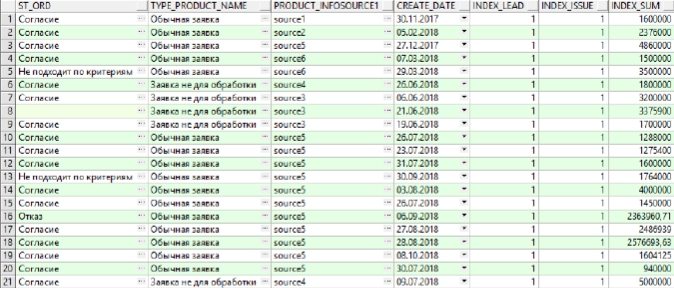

Поля таблицы:

ST_ORD (Varchar) — статус заявки;

TYPE_PRODUCT_NAME (Varchar) — тип заявки;

PRODUCT_INFOSOURCE1 (Varchar) — источник;

CREATE_DATE (Date) — дата создания заявки;

INDEX_LEAD (Number) — индикатор заявки (флаг 0/1 определяет регистрацию лида в системе);

INDEX_ISSUE (Number) — индикатор выдачи (флаг 0/1 определяет наличие выдачи по заявке);

INDEX_SUM (Number) — сумма по продукту.


Задание 1. Сгруппируйте по месяцам количество заявок и сумму выдач, вычислите долю выдач.

Задание 2. Определите источник, через который пришло больше всего заявок.

Задание 3. Выделите количество заявок, которые являются ошибочными.

Критерии ошибки:

Статус заявки не проставляется или имеет значение «тестовая заявка».
Заявка была создана в августе 2018 года.
Присутствует индикатор выдачи, но при этом лид не был зарегистрирован в системе.

Задание 4. Каким будет результат выполнения запросов ниже, если в поле CREATE_DATE будет содержаться значение 30.11.2017?

select trunc(create_date, 'dd') , create_date from test_sql

select trunc(create_date, 'mm') , create_date from test_sql

select trunc(create_date, 'mm')+1, create_date from test_sql

Для выполнения ваших заданий на языке SQL, вам понадобятся следующие запросы:

Задание 1
Сгруппируйте по месяцам количество заявок и сумму выдач, вычислите долю выдач:


SELECT 
    TO_CHAR(CREATE_DATE, 'YYYY-MM') AS month,
    COUNT(*) AS total_requests,
    SUM(CASE WHEN INDEX_ISSUE = 1 THEN INDEX_SUM ELSE 0 END) AS total_issues,
    SUM(CASE WHEN INDEX_ISSUE = 1 THEN 1 ELSE 0 END) / COUNT(*)::float AS issue_ratio
FROM 
    TEST_SQL
GROUP BY 
    TO_CHAR(CREATE_DATE, 'YYYY-MM')
ORDER BY 
    month;



Задание 2
Определите источник, через который пришло больше всего заявок:

SELECT 
    PRODUCT_INFOSOURCE1 AS source,
    COUNT(*) AS total_requests
FROM 
    TEST_SQL
GROUP BY 
    PRODUCT_INFOSOURCE1
ORDER BY 
    total_requests DESC
LIMIT 1;



Задание 3
Выделите количество заявок, которые являются ошибочными:

SELECT 
    COUNT(*) AS error_requests
FROM 
    TEST_SQL
WHERE 
    (ST_ORD IS NULL OR ST_ORD = 'тестовая заявка')
    OR TO_CHAR(CREATE_DATE, 'YYYY-MM') = '2018-08'
    OR (INDEX_ISSUE = 1 AND INDEX_LEAD = 0);


Задание 4

Давайте рассмотрим каждый запрос по отдельности и определим результат, если в поле CREATE_DATE будет значение 30.11.2017.

Первый запрос:

SELECT trunc(create_date, 'dd'), create_date FROM test_sql;
Функция TRUNC(create_date, 'dd') обрезает дату до начала дня. Поскольку дата уже указана с точностью до дня, результат будет:

30.11.2017 00:00:00, 30.11.2017
Второй запрос:

SELECT trunc(create_date, 'mm'), create_date FROM test_sql;
Функция TRUNC(create_date, 'mm') обрезает дату до начала месяца. Результат будет:

01.11.2017 00:00:00, 30.11.2017
Третий запрос:

SELECT trunc(create_date, 'mm') + 1, create_date FROM test_sql;
Функция TRUNC(create_date, 'mm') + 1 обрезает дату до начала месяца и добавляет один день. Результат будет:

02.11.2017 00:00:00, 30.11.2017
Таким образом, результаты выполнения запросов будут следующими:

30.11.2017 00:00:00, 30.11.2017
01.11.2017 00:00:00, 30.11.2017
02.11.2017 00:00:00, 30.11.2017

## *10. Дополнительные задачи по SQL

✍ Для поддержания формы предлагаем вам периодически решать задачи с использованием SQL.

Мы подготовили отдельный курс с практическими заданиями по SQL: они составлены так, чтобы максимально приблизить вас к реальным задачам.

Чтобы записаться на курс, достаточно заполнить форму.

Чтобы записаться на курс, достаточно заполнить [форму](https://forms.yandex.ru/cloud/643fa4aff47e730ee14b575a/).

[Перейти к курсу](https://lms.skillfactory.ru/courses/course-v1:SkillFactory+SQLQ+2021/course/)